In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from sklearn import metrics
from tqdm import tqdm

data_dir = "/export/gaon1/data/jteneggi/data/lisa"
datasets_dir = os.path.join(data_dir, "datasets")
train_dir = os.path.join(datasets_dir, "train")
test_dir = os.path.join(datasets_dir, "test")
annotations_dir = os.path.join(data_dir, "Annotations", "Annotations")
day_train_annotations_dir = os.path.join(annotations_dir, "dayTrain")
day_train_clip_dirs = os.listdir(day_train_annotations_dir)

day_test_sequences = []
for sequence_name in tqdm(["daySequence1", "daySequence2"]):
    day_test_sequence_df = pd.read_csv(os.path.join(annotations_dir, sequence_name, "frameAnnotationsBOX.csv"), sep=";")
    day_test_sequences.append(day_test_sequence_df)
day_test_df = pd.concat(day_test_sequences, axis=0)
day_test_df.head()
go_rule = lambda row: 1 if "go" in row["Annotation tag"] else 0
day_test_df["Classification"] = day_test_df.apply(go_rule, axis=1)

exp_mapper = ["hexp/relative_70", "partexp", "gradexp", "deepexp", "lime"]

true_positives = np.load("true_positives.npy", allow_pickle=True)
np.random.seed(0)
examples = np.random.choice(true_positives, size=300, replace=False)

comp_times = np.load(os.path.join("true_positive_explanations", f"comp_times.npy"), allow_pickle=True).item()

exp_df_clips = []
for exp_name in tqdm(exp_mapper):
    exp_df_path = os.path.join("true_positive_explanations", exp_name, "f1_scores.csv")
    
    if os.path.exists(exp_df_path):
        exp_df = pd.read_csv(exp_df_path)
    else:
        exp_df = pd.DataFrame(columns=["image_name", "exp_name", "f1", "comp_time"])
        if "hexp" in exp_name or exp_name == "lime_fast":
            exp_comp_times = np.load(os.path.join("true_positive_explanations", exp_name, "comp_times.npy"), allow_pickle=True)
        else:
            exp_comp_times = comp_times[exp_name]
        
        explanation_dir = os.path.join("true_positive_explanations", exp_name)
        scores = []
        for i, image_path in enumerate(examples):
            image_name = os.path.basename(image_path)
            image_filename = f"dayTest/{image_name}"
            
            ground_truth = np.zeros((960, 1280))        

            annotations = day_test_df.loc[day_test_df["Filename"] == image_filename]
            for j, annotation in annotations.iterrows():
                if annotation["Classification"] == 1:
                    upper_left_c = int(annotation["Upper left corner X"])
                    upper_left_r = int(annotation["Upper left corner Y"])
                    lower_right_c = int(annotation["Lower right corner X"])
                    lower_right_r = int(annotation["Lower right corner Y"])
                    ground_truth[upper_left_r:lower_right_r+1, upper_left_c:lower_right_c+1] = 1

            explanation = np.load(os.path.join(explanation_dir, "%s.npy" % image_name))
            score = metrics.f1_score(ground_truth.flatten(), explanation.flatten() > 0)
            
            if exp_comp_times[i] > 0 and score > 0:
                exp_df = exp_df.append({"image_name": image_name, "exp_name": exp_name, "f1": score, "comp_time": exp_comp_times[i]}, ignore_index=True)
        exp_df.to_csv(exp_df_path)
    exp_df_clips.append(exp_df)
df = pd.concat(exp_df_clips, axis=0)

100%|██████████| 5/5 [00:00<00:00, 410.56it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


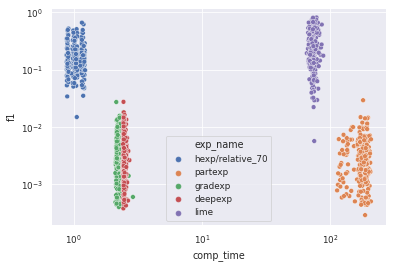

In [2]:
sns.set_theme()
sns.set_context("paper")

sns.scatterplot(data=df, x="comp_time", y="f1", hue="exp_name", legend=True)
plt.xscale("log")
plt.yscale("log")
plt.savefig("f1_time_seaborn.eps")
plt.savefig("f1_time_seaborn.jpg")